In [111]:
import gurobipy as gp
import itertools as it
import networkx as nx
import pandas as pd
import numpy as np
import math
import re


import seaborn as sns
import matplotlib.pyplot as plt

"""
implementation of solving profit maximization problem
author: 
yk796@cornell.edu
"""

'\nimplementation of solving profit maximization problem\nauthor: \nyk796@cornell.edu\n'

In [112]:
# Cautiom : if we change demand, we need to change demand here as well

"""
configuration
"""
# fuel_cost_per_min = 0.08 # USD per min
vot = 20 #$/hr
p_sen = 1/vot*60 # cost to min
Transit_ASC = -10 #0000

n_ods = 100
dist = 1
alpha = 0.15
beta = 4.0
transit_scenario = 2
n_bins = 10
oper_cost = 0.08
mip_gap = 0.05
time_limit = 10800
toll = None
fleet_size = None
exo_private = 0.0


if fleet_size is None:
    file_name = "ods_{}_dist_{}_alpha_{}_beta_{}_transit_{}_bin_{}_opercost_{}_gap_{}_timelimit_{}_exo_private_{}".format(n_ods, dist, alpha, beta, transit_scenario, n_bins, oper_cost, mip_gap, time_limit, exo_private) 
elif toll is not None:
    file_name = "ods_{}_dist_{}_alpha_{}_beta_{}_transit_{}_bin_{}_opercost_{}_gap_{}_timelimit_{}_exo_private_{}_toll_{}".format(n_ods, dist, alpha, beta, transit_scenario, n_bins, oper_cost, mip_gap, time_limit, exo_private, toll) 
elif (toll is None) and (fleet_size is not None):
    file_name = "ods_{}_dist_{}_alpha_{}_beta_{}_transit_{}_bin_{}_opercost_{}_gap_{}_timelimit_{}_exo_private_{}_fleet_size_{}".format(n_ods, dist, alpha, beta, transit_scenario, n_bins, oper_cost, mip_gap, time_limit, exo_private, fleet_size) 

output_name = "../output/" +file_name+".txt"



if transit_scenario == 1:
    transit_line = []  
elif transit_scenario == 2:
    transit_line = [(4, 11), (11, 14), (14, 23), (23, 24), (5, 9), (9, 10), (10, 15), (15, 22), (22, 21),
                (11, 4), (14, 11), (23, 14), (24, 23), (9, 5), (10, 9), (15, 10), (22, 15), (21, 22)]  
elif transit_scenario == 3:
    transit_line = [(1, 3), (3, 12), (12, 13), (4, 11), (11, 14), (14, 23), (23, 24), (5, 9), (9, 10), (10, 15), (15, 22), (22, 21), (2, 6), (6, 8), (8, 16), (16, 17), (17, 19), (19, 20),
                    (3, 1), (12, 3), (13, 12), (11, 4), (14, 11), (23, 14), (24, 23), (9, 5), (10, 9), (15, 10), (22, 15), (21, 22), (6, 2), (8, 6), (16, 8), (17, 16), (19, 17), (20, 19)]  
elif transit_scenario == 4:
    transit_line = [(2, 6), (6, 8), (8, 16), (16, 17), (17, 19), (19, 20), (20, 21), (21, 24), (24, 13), (12, 11), (11, 10), (10, 16),
                    (6, 2), (8, 6), (16, 8), (17, 16), (19, 17), (20, 19), (21, 20), (24, 21), (13, 24), (11, 12), (10, 11), (16, 10)]  
elif transit_scenario == 5: # additional transit lines
    transit_line = [(2, 6), (6, 8), (8, 16), (16, 17), (17, 19), (19, 20), (20, 21), (21, 24), (24, 13), (12, 11), (11, 10), (10, 16), (24, 23), (23, 14), (14, 11), 
                    (6, 2), (8, 6), (16, 8), (17, 16), (19, 17), (20, 19), (21, 20), (24, 21), (13, 24), (11, 12), (10, 11), (16, 10), (23, 24), (14, 23), (11, 14)]  
    



In [113]:
# link to https://github.com/bstabler/TransportationNetworks/tree/master/SiouxFalls

network_df = pd.read_csv("../data/SiouxFalls/SiouxFalls_net.txt", sep='\t', comment=';')
node_df = pd.read_csv("../data/SiouxFalls/SiouxFalls_node.txt", sep='\t', comment=';')
if dist == 1:
    od_df = pd.read_csv("../data/SiouxFalls/SiouxFalls_od.csv")
elif dist == 2:
    od_df = pd.read_csv("../data/SiouxFalls/SiouxFalls_od_dist2.csv")

network_df = network_df[['init_node', 'term_node', 'capacity', 'length', 'free_flow_time', 'b',
       'power', 'speed', 'toll', 'link_type']]
network_df[['init_node', 'term_node']] = network_df[['init_node', 'term_node']].astype(int)
node_df = node_df[['Node', 'X', 'Y']]

print("Number of nodes:", len(node_df))
print("Number of links:", len(network_df))
print("Number of od pairs:", len(od_df))


if toll is None:
    tolling_roads = []  
else:
    # tolling_roads = [(6, 8), (14, 11), (16, 17), (17, 19), (19, 17)] # exo_private = 0.33

    tolling_roads = [(10, 16), (11, 14), (14, 11), (16, 10), (17, 19)] # exo_private = 1
if tolling_roads:
    toll_cost = {(int(row['init_node']), int(row['term_node'])): toll if (int(row['init_node']), int(row['term_node'])) in tolling_roads else 0 for _, row in network_df.iterrows()}
else:
    toll_cost = {(int(row['init_node']), int(row['term_node'])): 0 for _, row in network_df.iterrows()}
 


Number of nodes: 24
Number of links: 76
Number of od pairs: 528


In [114]:
# od_df = od_df[(od_df['O']==1)&(od_df['D']==24)|(od_df['O']==20)&(od_df['D']==2)]
if n_ods < len(od_df):
    od_df = od_df.sample(n=n_ods, random_state=42)

In [115]:
# import folium
# import json

# # Path to the GeoJSON file
# geojson_path = '../data/SiouxFalls/SiouxFalls_geo.json'

# # Load GeoJSON data from the file
# with open(geojson_path, 'r') as f:
#     siouxfalls_geojson = json.load(f)

# # Initialize a map centered around the first feature's coordinates
# first_feature_coords = siouxfalls_geojson['features'][0]['geometry']['coordinates'][::-1]  # Reverse to [lat, lon]
# m = folium.Map(location=first_feature_coords, zoom_start=13)

# # Add the GeoJSON to the map
# folium.GeoJson(siouxfalls_geojson, name="SiouxFalls Network").add_to(m)

# # Add a layer control panel to switch between layers
# folium.LayerControl().add_to(m)

# # Display the map
# m.save('../figures/SiouxFalls_network.html')


In [116]:
def plot_od_heatmap(df, value_column, title, cmap='Reds', save_path=None, figsize=(10, 8), annot=False):
    """
    This function plots and saves a heatmap for an OD matrix.

    Parameters:
    - df: DataFrame containing the OD data.
    - value_column: The name of the column in df that contains the values to plot.
    - title: Title for the heatmap.
    - cmap: Colormap to be used for heatmap.
    - save_path: Path to save the figure (including the filename).
    - figsize: Size of the figure.
    - annot: If True, the values will be shown on the heatmap.
    """
    # Pivot the table to get a matrix where index is 'O', columns are 'D', and cell values are the specified 'value_column'
    od_matrix_pivot = df.pivot(index='O', columns='D', values=value_column).fillna(0)

    # Plotting the heatmap
    plt.figure(figsize=figsize)
    heatmap = sns.heatmap(od_matrix_pivot, cmap=cmap, linewidths=.5, annot=annot)
    plt.title(title)
    plt.xlabel('Destination Node ID')
    plt.ylabel('Origin Node ID')

    # If a save path is provided, save the figure
    if save_path:
        plt.savefig(save_path)

    # Show the heatmap
    plt.show()
    return od_matrix_pivot
# Example usage:
# Assuming od_df is a DataFrame with the OD data and 'Ton' column as values.
# plot_od_heatmap(od_df, 'Ton', 'OD Matrix Heatmap', save_path='/mnt/data/od_matrix_heatmap.pdf')


In [117]:
od_df['Ton'] = od_df['Ton']*(1-exo_private)

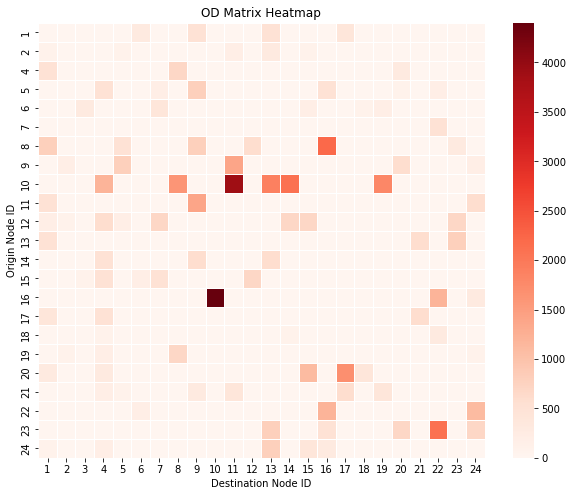

In [118]:
od_matrix_pivot = plot_od_heatmap(od_df, 'Ton', 'OD Matrix Heatmap', save_path='../figures/od_matrix_heatmap.pdf', annot=False)


In [119]:
total_demand = od_df['Ton'].sum()
total_demand

64800.0

In [120]:
def generate_route_sets_link_elimination(graph, source, target, num_routes):
    route_sets = []
    for i in range(num_routes):
        path = nx.shortest_path(graph, source=source, target=target, weight='weight')
        if path not in route_sets:
            route_sets.append(path)
        
        if len(path) > 2:
            edge_to_remove = (path[1], path[2])
            original_weight = graph[edge_to_remove[0]][edge_to_remove[1]]['weight']
            graph[edge_to_remove[0]][edge_to_remove[1]]['weight'] = float('inf')
            
        else:
            break
        
    # Reset graph weights for future usage
    nx.set_edge_attributes(graph, original_weight, 'weight')
    
    return route_sets

# link penalty approach
def generate_route_sets_link_penalty(graph, source, target, num_routes, penalty_factor=1.5):
    route_sets = []
    for i in range(num_routes):
        path = nx.shortest_path(graph, source=source, target=target, weight='weight')
        if path not in route_sets:
            route_sets.append(path)
        
        for j in range(len(path) - 1):
            edge = (path[j], path[j+1])
            graph[edge[0]][edge[1]]['weight'] *= penalty_factor 
            
    # Reset graph weights for future usage
    nx.set_edge_attributes(graph, 1, 'weight')
    
    return route_sets


In [121]:
if transit_line:
    transit_link = []

    for index, row in network_df.iterrows():
        init_node, term_node = int(row['init_node']), int(row['term_node'])
        length = row['length']
        if (init_node, term_node) in transit_line:
            transit_link.append((init_node, term_node, length*0.5))
        else:
            transit_link.append((init_node, term_node, length*3))

In [122]:
# input
n_nodes = len(node_df)


n_alternative = 1
n_routes = 3

# road_bpr_dict = {(row['init_node'], row['term_node']): lambda flow: row['free_flow_time']*(1+row['b']*(flow/row['capacity'])**row['power']) for index, row in network_df.iterrows()}

bpr_func = {}
oper_cost_func = {}
link_capacity = {}
free_flow_time_dict = {}

for index, row in network_df.iterrows():
    init_node, term_node = int(row['init_node']), int(row['term_node'])
    free_flow_time, b, capacity, power = row['free_flow_time'], row['b'], row['capacity'], row['power']
    free_flow_time_dict[((init_node, term_node))] = free_flow_time
    bpr_func[(init_node, term_node)] = lambda flow, f=free_flow_time, c=capacity, p=power: f * (1 + alpha * (flow / c)) # 1 should be substitue with power
    oper_cost_func[(init_node, term_node)] = lambda flow, f=free_flow_time, c=capacity, p=power: oper_cost * f * (1 + alpha * (flow / c))  #TODO: include toll price
    #oper_cost = {(int(row['init_node']), int(row['term_node'])): row['length']*oper_cost for _, row in network_df.iterrows()}

    link_capacity[(init_node, term_node)] = capacity



nodes = node_df['Node'].to_list()
alternatives = list(range(1, n_alternative+1))
arcs = list(network_df[['init_node', 'term_node']].to_records(index=False))
#ods = list(it.permutations(nodes, 2))
# ods = [(id1+1, id2+1) for id1, o in enumerate(O_demand) for id2, d in enumerate(D_demand) if o>0 or d>0 if id1 != id2]

demand = {(int(row['O']), int(row['D'])): row['Ton'] for index, row in od_df.iterrows()}
ods = list(demand.keys() )
road_link = [(int(row['init_node']), int(row['term_node']), row['length']) for _, row in network_df.iterrows()]
road_length = {(int(row['init_node']), int(row['term_node'])): row['length'] for _, row in network_df.iterrows()}


# Find shortest path travel time
OD_travel_time = {}
G = nx.DiGraph()
G.add_weighted_edges_from(road_link)
for od_pair_index in range(len(od_df)):
    i,j = od_df['O'].iloc[od_pair_index], od_df['D'].iloc[od_pair_index]
    # generate shortest path
    path_tt = nx.shortest_path_length(G, i, j, weight='weight')
    OD_travel_time[(i,j)] = path_tt


# Find shortest path travel time
OD_transit_time = {}
G = nx.DiGraph()
G.add_weighted_edges_from(transit_link)
for od_pair_index in range(len(od_df)):
    i,j = od_df['O'].iloc[od_pair_index], od_df['D'].iloc[od_pair_index]
    # generate shortest path
    path_tt = nx.shortest_path_length(G, i, j, weight='weight')
    OD_transit_time[(i,j)] = path_tt



OD_route = {}
for od_pair_index in range(len(od_df)):
    i,j = od_df['O'].iloc[od_pair_index], od_df['D'].iloc[od_pair_index]
    G = nx.DiGraph()
    G.add_weighted_edges_from(road_link)
    route_sets = generate_route_sets_link_penalty(G, i, j, n_routes) 
    OD_route[(i,j)] = route_sets
    
T = {}
for (s, t) in ods:
    T[(s, t), 1] = OD_travel_time[(s,t)] # MoD
    T[(s, t), 2] = OD_transit_time[(s,t)] # Transit

ASC = {}
for (s, t) in ods:
    ASC[(s, t), 1] = 0 # MoD
    ASC[(s, t), 2] = -10 # Transit


def create_route(od):
    (o, d) = od
    # find all possible routes
    return (o, d)
    

def indicator(arc, route): 
    '''
    To check if an arc is in route
    '''
    # Check if arc is a tuple and has 2 elements
    if not isinstance(arc, tuple) or len(arc) != 2:
        raise ValueError("Arc must be a tuple with 2 elements")

    # Iterate through the route and check each pair
    for i in range(len(route) - 1):
        if route[i] == arc[0] and route[i+1] == arc[1]:
            return True
    return False




In [123]:
def create_dict(var_of_interest, parse_type):
    result = {}  # Initialize an empty dictionary to store the data
    # Open the text file and read its contents
    with open('{}'.format(output_name), 'r') as file:
        for line in file:
            if line.startswith(var_of_interest):  # Check if the line starts with 'theta'
                # Use regular expressions to extract the required data
                if parse_type == 2:
                    match = re.match(r'{}\[(\d+),(\d+)\] = ([\d.e-]+)'.format(var_of_interest), line)
                    if match:
                        # Convert the extracted data to the required types and format
                        key = (int(match.group(1)), int(match.group(2)))
                        value = float(match.group(3))
                        # Store the data in the dictionary
                        result[key] = value
                elif parse_type == 1: 
                    match = re.match(r'{}\[(\d+)\] = ([\d.e-]+)'.format(var_of_interest), line)
                    if match:
                        # Convert the extracted data to the required types and format
                        key = int(match.group(1))
                        value = float(match.group(2))
                        # Store the data in the dictionary
                        result[key] = value
                elif parse_type == 3:
                    match = re.match(r'{}\[(\d+),(\d+),(\d+)\] = ([\d.e-]+)'.format(var_of_interest), line)
                    # print(match)
                    if match:
                        key = (int(match.group(1)), int(match.group(2)), int(match.group(3)))
                        value = float(match.group(4))
                        result[key] = value
                        # print(key)
                        # print(value)
    return result
# Output the result




In [124]:
theta_result_temp = create_dict("theta", 2)
congest_tt_result_temp = create_dict("congested_travel_time", 2)
f_vars_opt = create_dict("f", 1)
total_f_vars_opt = create_dict("total_f", 1)
y_vars_opt = create_dict("y", 3)
z_vars_opt = create_dict('z', 3)

In [125]:
theta_result = {}
for key, value in theta_result_temp.items():
    j_dim, od_dim = key[0], key[1]
    theta_result[ods[od_dim], alternatives[j_dim]] = value

congest_tt_result = {}
for key, value in congest_tt_result_temp.items():
    j_dim, od_dim = key[0], key[1]
    congest_tt_result[ods[od_dim], alternatives[j_dim]] = value


In [126]:
opt_oper_cost = {}
total_tax = {}
for (s,t) in ods:
    total_oper_cost = 0
    tax = 0
    for key, value in y_vars_opt.items():
        j_ind, a_ind, od_ind = key[0], key[1], key[2]
        # Check if the second element of the key is (1, 2)
        if ods[od_ind] == (s,t):
            # total_oper_cost += (oper_cost_func[tuple(arcs[a_ind])](f_vars_opt[a_ind]) + toll_cost[tuple(arcs[a_ind])]) * value
            total_oper_cost += (oper_cost_func[tuple(arcs[a_ind])](0) + toll_cost[tuple(arcs[a_ind])]) * value
            if toll is not None:
                tax += toll_cost[tuple(arcs[a_ind])] * value
            else:
                tax += oper_cost_func[tuple(arcs[a_ind])](0)/2 * value
    opt_oper_cost[(s,t)] = total_oper_cost
    total_tax[(s,t)] = tax

In [127]:
MoD_tt = {od: OD_travel_time[od]+congest_tt_result[(od, 1)] for (od_ind, od) in enumerate(OD_travel_time.keys())}

In [128]:
def prob_to_price(theta_result, congest_tt_result): 
     
    if len(theta_result) == 0:
        raise Exception("no theta values")
      
    # calculate theta^n_st for each pair st
    theta_n = {key: 1 for key in ods}
    for key, value in theta_result.items():
        od, j = key[0], key[1]
        theta_n[od] -= value

    theta_transit = {}
    for key, value in theta_n.items():
        theta_transit[key] = round(value,5)
    print('ms transit: ', theta_transit)

    # calculate l^j_st for each alternative j and pair st
    l = {}
    for key, value in theta_result.items():
        # l[key] = congest_tt_result[key] / theta_result[key] if theta_result[key] > 0 else 0 
        l[key] = congest_tt_result[key] if theta_result[key] > 0 else 0 
    print('l: ', l)
    
    
    
    # calculate pi^j_st for each alternative j and pair st
    pi = {}   
    for key, value in theta_result.items():
        od, j = key[0], key[1]
        V_n = ASC[(od, 2)] - T[(od, 2)]
        #pi[key] = (-1/p_sen) * (math.log(value) - math.log(theta_n[od]) + V_n - ASC[key] + T[key] + l[key])       

        # Check if 'value' and 'theta_n[od]' are greater than zero
        if value > 0 and theta_n[od] > 0 and p_sen != 0:
            pi[key] = (-1/p_sen) * (math.log(value) - math.log(theta_n[od]) + V_n - ASC[key] + T[key] + l[key])
        else:
            # Handle the error or assign a default value
            pi[key] = None  # or some other default value
            # You might want to print a warning or raise a custom error
            # print(f"Invalid value encountered for key {key}: value={value}, theta_n[od]={theta_n[od]}, p_sen={p_sen}")
            # print('pi: ', pi)
    
    
    return theta_transit, l, pi
        

In [129]:
theta_transit, l, pi = prob_to_price(theta_result, congest_tt_result)

ms transit:  {(10, 8): 0.1, (20, 18): 0.1, (8, 1): 0.1, (21, 19): 0.1, (21, 4): 1.0, (2, 11): 0.1, (23, 24): 0.1, (8, 23): 0.2, (20, 15): 0.1, (1, 6): 0.1, (12, 1): 0.1, (21, 5): 1.0, (18, 4): 0.1, (21, 9): 1.0, (5, 9): 0.1, (24, 16): 0.1, (4, 1): 0.1, (1, 9): 0.1, (6, 19): 0.1, (6, 7): 0.1, (22, 6): 0.4, (10, 13): 0.2, (8, 12): 0.1, (9, 20): 0.2, (11, 9): 0.1, (24, 4): 1.0, (4, 20): 0.1, (8, 5): 0.1, (12, 14): 0.1, (21, 11): 0.3, (14, 4): 0.4, (15, 3): 0.9, (2, 5): 0.1, (10, 19): 0.175, (9, 2): 0.2, (1, 17): 0.1, (5, 20): 0.3, (6, 18): 0.1, (11, 1): 0.1, (18, 14): 0.1, (10, 4): 0.2, (5, 16): 0.2, (14, 13): 0.2, (8, 16): 0.1, (16, 10): 0.1, (22, 24): 0.1, (15, 4): 0.9, (9, 11): 0.1, (5, 7): 0.1, (20, 4): 0.2, (12, 4): 0.1, (2, 13): 0.1, (12, 15): 0.1, (7, 22): 0.1, (12, 23): 0.1, (16, 22): 0.2, (9, 24): 1.0, (23, 13): 0.1, (5, 22): 1.0, (22, 16): 0.2, (13, 21): 0.1, (21, 17): 0.1, (19, 8): 0.1, (16, 24): 0.15, (19, 24): 0.1, (15, 7): 0.1, (4, 8): 0.1, (23, 22): 0.1, (1, 13): 0.1, (5, 4

In [130]:
# culculate social welfare by log-sum
expected_util = 0
for key, value in theta_result.items():
    od, j = key[0], key[1]
    
    V_n = - 10 - T[(od, 2)] - p_sen * 2.5
    if pi[(od, 1)]: 
        V_j = - MoD_tt[od] - p_sen * pi[(od, 1)]
        log_sum = np.log(np.exp(V_n) + np.exp(V_j))
    else:
        log_sum = V_n
    expected_util += demand[od]*log_sum/p_sen



print("total expected utility", expected_util)

total expected utility -587506.5942765451


In [131]:
# Create new dataframe to have all values
od_df['Price'] = od_df.apply(lambda row: pi.get(((row['O'], row['D']), 1)), axis=1)
od_df['Transit'] = od_df.apply(lambda row: theta_transit.get((row['O'], row['D'])), axis=1)
od_df['TravelTime'] = od_df.apply(lambda row: MoD_tt.get((row['O'], row['D'])), axis=1)
od_df['MoD'] = 1 - od_df['Transit']
od_df['MoD_Ton'] = od_df['Ton']*od_df['MoD']


In [132]:
od_df.to_csv('../od_df_fleetsize.csv', index=False)

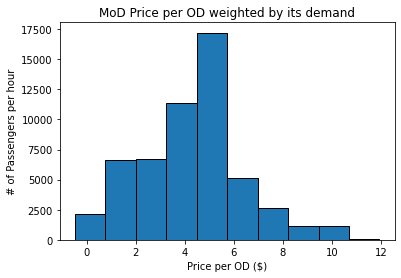

passengers 4.328494917580727 2.084971322828806


In [133]:
# Plotting the histogram weighted by 'Ton'
plt.hist(od_df['Price'], weights=od_df['MoD_Ton'], bins=10, edgecolor='black')
plt.xlabel('Price per OD ($)')
plt.ylabel('# of Passengers per hour')
plt.title('MoD Price per OD weighted by its demand')
plt.show()

# Calculating weighted average and standard deviation
valid_data = od_df.dropna(subset=['Price'])
# weighted_avg = np.average(valid_data['Price'], weights=valid_data['Ton'])
# variance = np.average((valid_data['Price'] - weighted_avg)**2, weights=valid_data['Ton'])
# weighted_std = np.sqrt(variance)

# print("suggested", weighted_avg, weighted_std)


weighted_avg = np.average(valid_data['Price'], weights=valid_data['MoD_Ton'])
variance = np.average((valid_data['Price'] - weighted_avg)**2, weights=valid_data['MoD_Ton'])
weighted_std = np.sqrt(variance)

print("passengers", weighted_avg, weighted_std)


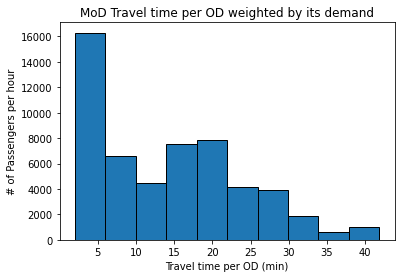

passengers:  14.344869893113946 9.465872871299256


In [134]:
# Plotting the histogram weighted by 'Ton'
plt.hist(od_df['TravelTime'], weights=od_df['MoD_Ton'], bins=10, edgecolor='black')
plt.xlabel('Travel time per OD (min)')
plt.ylabel('# of Passengers per hour')
plt.title('MoD Travel time per OD weighted by its demand')
plt.show()

# Calculating weighted average and standard deviation
valid_data = od_df.dropna(subset=['TravelTime'])
# weighted_avg = np.average(valid_data['TravelTime'], weights=valid_data['Ton'])
# variance = np.average((valid_data['TravelTime'] - weighted_avg)**2, weights=valid_data['Ton'])
# weighted_std = np.sqrt(variance)
# print("suggested", weighted_avg, weighted_std)


weighted_avg = np.average(valid_data['TravelTime'], weights=valid_data['MoD_Ton'])
variance = np.average((valid_data['TravelTime'] - weighted_avg)**2, weights=valid_data['MoD_Ton'])
weighted_std = np.sqrt(variance)
print("passengers: ", weighted_avg, weighted_std)
# print("Total travel time of the passenger:", sum(valid_data['TravelTime']))


In [135]:
valid_data

,O,D,Ton,Price,Transit,TravelTime,MoD,MoD_Ton
158,10,8,1600.0,4.173900,0.10,17.281074,0.90,1440.0
395,20,18,400.0,5.267592,0.10,4.000000,0.90,360.0
6,8,1,800.0,7.352329,0.10,24.745789,0.90,720.0
417,21,19,400.0,1.364215,0.10,15.210130,0.90,360.0
79,21,4,200.0,NaN,1.00,18.000000,0.00,0.0
...,...,...,...,...,...,...,...,...
93,12,5,200.0,5.267312,0.10,19.000840,0.90,180.0
316,6,15,200.0,1.093626,0.25,24.620511,0.75,150.0
355,23,16,500.0,2.735655,0.10,27.095811,0.90,450.0
457,17,21,600.0,2.078315,0.10,19.067830,0.90,540.0


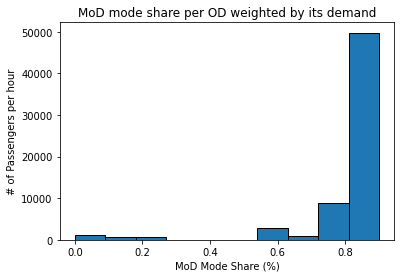

(0.8372878086419753, 0.1661706401076261)

In [136]:
# Plotting the histogram weighted by 'Ton'
plt.hist(od_df['MoD'], weights=od_df['Ton'], bins=10, edgecolor='black')
plt.xlabel('MoD Mode Share (%)')
plt.ylabel('# of Passengers per hour')
plt.title('MoD mode share per OD weighted by its demand')
plt.show()

# Calculating weighted average and standard deviation
valid_data = od_df.dropna(subset=['MoD'])
weighted_avg = np.average(valid_data['MoD'], weights=valid_data['Ton'])
variance = np.average((valid_data['MoD'] - weighted_avg)**2, weights=valid_data['Ton'])
weighted_std = np.sqrt(variance)

weighted_avg, weighted_std

In [137]:
def rev(demand, theta_dict, pi):
    revenue = 0
    for key, value in theta_dict.items():
        od = (key[0][0], key[0][1])        
        revenue += demand[od] * value * pi[key] if (pi[key] is not None) and (pi[key] > 0) else 0 # Note: restrict the price to be positive
    
    print('revenue: ', revenue)
    return revenue

         OD_Index   PiValue
0    ((10, 8), 1)  4.173900
1   ((20, 18), 1)  5.267592
2     ((8, 1), 1)  7.352329
3   ((21, 19), 1)  1.364215
4    ((21, 4), 1)       NaN
..            ...       ...
95   ((12, 5), 1)  5.267312
96   ((6, 15), 1)  1.093626
97  ((23, 16), 1)  2.735655
98  ((17, 21), 1)  2.078315
99  ((20, 17), 1)  4.688712

[100 rows x 2 columns]


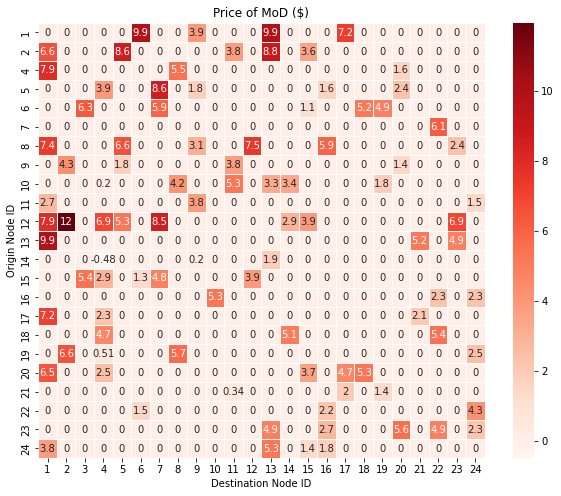

D,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
O,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,9.934258,0.000000,0.000000,3.933659,0.000000,...,0.000000,0.000000,7.240923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,6.600925,0.000000,0.000000,0.000000,8.600925,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.579684,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,7.934258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.516406,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.649573,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,3.934258,0.000000,0.000000,8.600925,0.000000,1.767592,0.000000,...,0.000000,1.586428,0.000000,0.000000,0.000000,2.370415,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,6.264469,0.000000,0.000000,0.000000,5.934258,0.000000,0.000000,0.000000,...,1.093626,0.000000,0.000000,5.156873,4.919828,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.133915,0.000000,0.000000
8,7.352329,0.000000,0.000000,0.000000,6.600925,0.000000,0.000000,0.000000,3.100593,0.000000,...,0.000000,5.934258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.404125,0.000000
9,0.000000,4.295833,0.000000,0.000000,1.767592,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.445157,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.204406,0.000000,0.000000,0.000000,4.173900,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.839971,0.000000,0.000000,0.000000,0.000000,0.000000


In [138]:
# Convert the dictionary to a DataFrame
pi_df = pd.DataFrame(list(pi.items()), columns=['OD_Index', 'PiValue'])
print(pi_df)
pi_df[['OD', 'Index']] = pd.DataFrame(pi_df['OD_Index'].tolist(), index=pi_df.index)
pi_df[['O', 'D']] = pd.DataFrame(pi_df['OD'].tolist(), index=pi_df.index)
pi_df.drop(columns=['OD_Index', 'OD', 'Index'], inplace=True)

# Use the defined function to plot the heatmap for the 'pi' DataFrame
plot_od_heatmap(pi_df, 'PiValue', 'Price of MoD ($)', save_path='../figures/price_heatmap.pdf', annot=True)

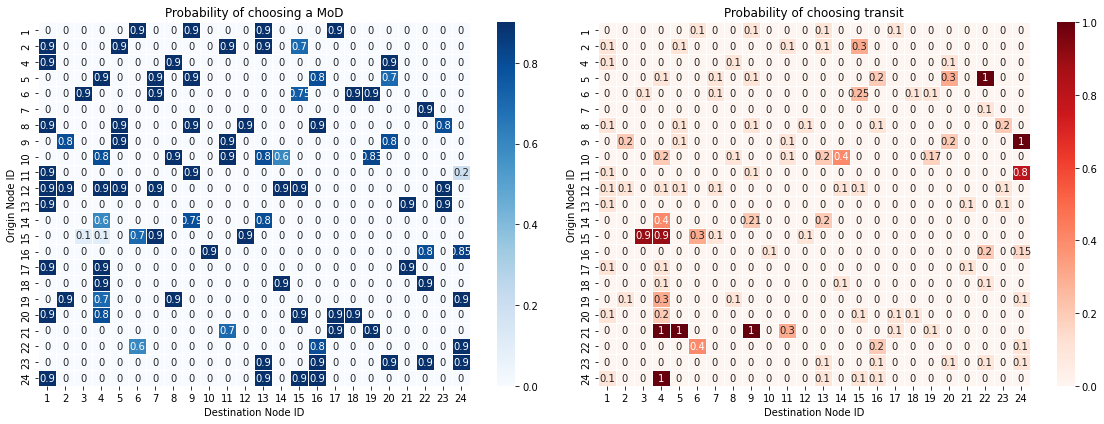

In [139]:
def plot_heatmap(data, ax, title, color='Reds'):
    """
    This function plots a heatmap for the given data on the provided Axes object.
    
    Parameters:
    - data: DataFrame to be plotted.
    - ax: Axes object where the heatmap will be plotted.
    - title: Title for the heatmap.
    - color: Color scheme for the heatmap.
    """
    sns.heatmap(data, cmap=color, linewidths=.5, annot=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Destination Node ID')
    ax.set_ylabel('Origin Node ID')

# Convert ms_transit dictionary into a DataFrame, pivot it, and prepare it for plotting
theta_transit_df = pd.DataFrame(list(theta_transit.items()), columns=['OD', 'prob'])
theta_transit_df[['O', 'D']] = pd.DataFrame(theta_transit_df['OD'].tolist(), index=theta_transit_df.index)
theta_transit_df.drop(columns='OD', inplace=True)
theta_transit_pivot = theta_transit_df.pivot(index='O', columns='D', values='prob').fillna(0)

# Convert theta_result to a DataFrame
theta_result_df = pd.DataFrame(list(theta_result.items()), columns=['OD_Index', 'prob'])
theta_result_df[['OD', 'Index']] = pd.DataFrame(theta_result_df['OD_Index'].tolist(), index=theta_result_df.index)
theta_result_df[['O', 'D']] = pd.DataFrame(theta_result_df['OD'].tolist(), index=theta_result_df.index)
theta_result_df.drop(columns=['OD_Index', 'OD', 'Index'], inplace=True)

# Pivot the DataFrame for theta_result
theta_result_pivot = theta_result_df.pivot(index='O', columns='D', values='prob').fillna(0)


# Set up the matplotlib figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the heatmaps using the defined function
plot_heatmap(theta_result_pivot, axes[0], 'Probability of choosing a MoD', color='Blues')
plot_heatmap(theta_transit_pivot, axes[1], 'Probability of choosing transit', color='Reds')

# Adjust layout
plt.tight_layout()
plt.savefig('../figures/Probability.pdf')


In [140]:

def dict_to_pivot(dict):
    # Convert the OD_travel_time dictionary into a DataFrame
    df = pd.DataFrame(list(dict.items()), columns=['OD', 'value'])
    # Split the 'OD' column into two separate columns 'O' and 'D'
    df[['O', 'D']] = pd.DataFrame(df['OD'].tolist(), index=df.index)
    # Drop the now unnecessary 'OD' column
    df.drop(columns='OD', inplace=True)  
    # Pivot the DataFrame to have 'O' as rows, 'D' as columns, and 'travel_time' as values
    df_pivot = df.pivot(index='O', columns='D', values='value').fillna(0)
    # Return the pivoted DataFrame
    return df_pivot


In [141]:
OD_travel_time_pivot = dict_to_pivot(OD_travel_time)
MoD_tt_pivot = dict_to_pivot(MoD_tt)
OD_transit_time_pivot = dict_to_pivot(OD_transit_time)


In [142]:
print("Total travel time:")
(od_matrix_pivot * theta_result_pivot * MoD_tt_pivot).sum().sum()


Total travel time:


778298.8471382782

In [143]:
type(od_matrix_pivot)

pandas.core.frame.DataFrame

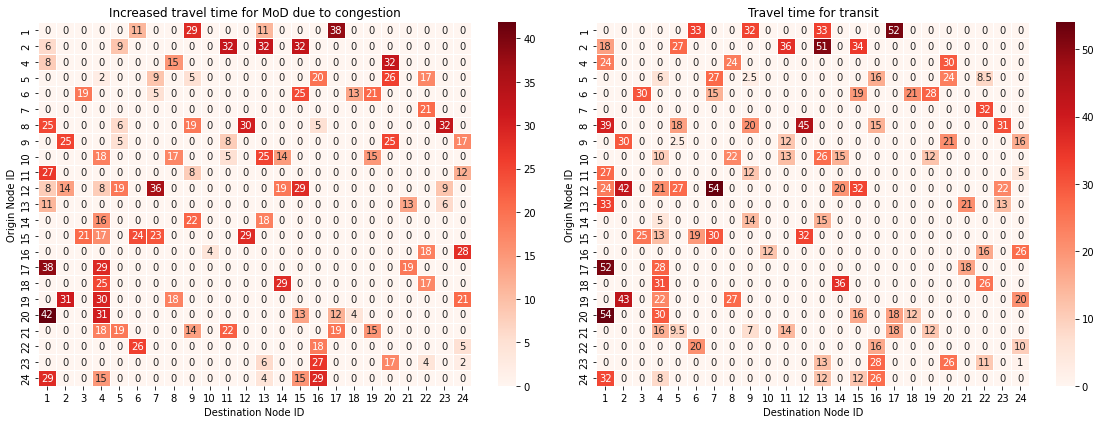

In [144]:
# Set up the matplotlib figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot the heatmaps using the defined function
# plot_heatmap(OD_travel_time_pivot, axes[0], 'Shortest travel time for MoD', color='Reds')
plot_heatmap(MoD_tt_pivot, axes[0], 'Increased travel time for MoD due to congestion', color='Reds')
plot_heatmap(OD_transit_time_pivot, axes[1], 'Travel time for transit', color='Reds')


# Adjust layout
plt.tight_layout()
plt.savefig('../figures/Travel time.pdf')

In [145]:
theta_result

{((10, 8), 1): 0.9000000000000469,
 ((20, 18), 1): 0.9,
 ((8, 1), 1): 0.8999999999999999,
 ((21, 19), 1): 0.8999999999999999,
 ((21, 4), 1): 0.0,
 ((2, 11), 1): 0.900000000000047,
 ((23, 24), 1): 0.9,
 ((8, 23), 1): 0.8,
 ((20, 15), 1): 0.9000000000000469,
 ((1, 6), 1): 0.8999999999999999,
 ((12, 1), 1): 0.9,
 ((21, 5), 1): 0.0,
 ((18, 4), 1): 0.9000000000000643,
 ((21, 9), 1): 0.0,
 ((5, 9), 1): 0.8999999999999999,
 ((24, 16), 1): 0.8999999999999999,
 ((4, 1), 1): 0.9,
 ((1, 9), 1): 0.900000000000047,
 ((6, 19), 1): 0.9000000000000469,
 ((6, 7), 1): 0.8999999999999999,
 ((22, 6), 1): 0.5999999999999954,
 ((10, 13), 1): 0.8,
 ((8, 12), 1): 0.9000000000000469,
 ((9, 20), 1): 0.7999999999999797,
 ((11, 9), 1): 0.9,
 ((24, 4), 1): 0.0,
 ((4, 20), 1): 0.9,
 ((8, 5), 1): 0.8999999999999999,
 ((12, 14), 1): 0.9000000000000643,
 ((21, 11), 1): 0.7000000000000001,
 ((14, 4), 1): 0.6000000000000001,
 ((15, 3), 1): 0.09999999999999998,
 ((2, 5), 1): 0.9,
 ((10, 19), 1): 0.8250000000000097,
 ((9,

In [146]:
total_rev = rev(demand, theta_result, pi)

revenue:  234990.78431851344


In [147]:
total_profit = total_rev - sum(opt_oper_cost.values())
print("profit", total_profit)

profit 201464.64009108278


In [148]:
print("Total tax collected:", sum(total_tax.values()))

Total tax collected: 16763.072113715323


In [149]:
f_vars_opt

{0: 1060.000000000001,
 1: 1100.0000000000177,
 2: 1620.0000000000186,
 3: 1040.0000000000055,
 4: 539.9999999999999,
 5: 1655.0000000000073,
 6: 1075.000000000037,
 7: 810.0000000000281,
 8: 3885.0000000000227,
 9: 180.0,
 10: 2730.0000000000437,
 11: 2160.0000000000327,
 12: 1884.99999999999,
 13: 1600.0000000000232,
 14: 1731.7984141507536,
 15: 2850.0000000000373,
 16: 719.9999999999912,
 17: 1750.1736593787587,
 18: 2981.798414150776,
 19: 1300.0000000000048,
 20: 720.0,
 21: 1640.0000000000791,
 22: 1158.2015858492898,
 23: 0.0,
 24: 2921.24999999999,
 25: 1474.4515858492896,
 26: 2780.000000000001,
 27: 353.2344183000132,
 28: 3051.765581700067,
 29: 0.0,
 30: 490.00000000000006,
 31: 1090.0000000000273,
 32: 2454.413365,
 33: 2438.2541435,
 34: 1359.9999999999984,
 35: 1058.2541434999805,
 36: 1991.7458565001095,
 37: 880.5866350000515,
 38: 1836.7458565000907,
 39: 2454.413365000046,
 40: 428.2541434999355,
 41: 600.0000000000188,
 42: 920.0000000000114,
 43: 764.4133649999999

In [150]:
bkf_df = pd.read_csv('../data/SiouxFalls/SiouxFalls_flow.tntp', delim_whitespace=True)
car_flow = {(int(row['From']),int(row['To'])): float(row['Volume']) for index, row in bkf_df.iterrows()} # Note: 1/3 of vehicle is used
car_flow_final = {}

# level of service is normally measured by volumn to capacity ratio
congest_index = {}
congest_index_car = {}
for (a_ind, (i,j)) in enumerate(arcs):
    congest_index[(i,j)] = total_f_vars_opt[a_ind]/link_capacity[(i,j)]

    # For trouble shooting
    car_flow_final[a_ind] = car_flow[(i,j)]/3
    congest_index_car[(i,j)] = car_flow_final[a_ind]/link_capacity[(i,j)]
    

# Initialize variables to store total weighted congestion and total length
total_weighted_congestion = 0
total_length = 0

# Loop through the road links and calculate the total weighted congestion and total length
for (i, j, length) in road_link:
    if (i, j) in congest_index:
        congestion = congest_index[(i, j)]
        total_weighted_congestion += congestion * length
        total_length += length

# Calculate the average congestion level weighted by arc length
if total_length > 0:
    average_weighted_congestion = total_weighted_congestion / total_length
else:
    average_weighted_congestion = 0

print("Average Congestion Level Weighted by Arc Length:", average_weighted_congestion)

# sum(congest_index.values()) / len(congest_index)

Average Congestion Level Weighted by Arc Length: 0.19255081863940238


/tmp/ipykernel_11667/247469838.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bkf_df = pd.read_csv('../data/SiouxFalls/SiouxFalls_flow.tntp', delim_whitespace=True)


In [151]:
# Sort the dictionary by values in descending order
sorted_congestion = sorted(congest_index.items(), key=lambda item: item[1], reverse=True)

# Identify the top three values
top_congest = sorted_congestion[:5]

# Print the dictionary with indicators
for key, value in congest_index.items():
    print(f"{key}") if (key, value) in top_congest else ''
    

(10, 16)
(16, 17)
(17, 16)
(17, 19)
(19, 17)


In [152]:
sorted_congestion

[((19, 17), 1.0339620038668706),
 ((17, 16), 0.9099418234858844),
 ((17, 19), 0.7),
 ((10, 16), 0.628592647618721),
 ((16, 17), 0.6112467601146976),
 ((16, 8), 0.608780503797359),
 ((8, 6), 0.608705739211505),
 ((6, 8), 0.5818003485815424),
 ((16, 10), 0.5518803352906996),
 ((20, 19), 0.5037372946537642),
 ((14, 11), 0.5033136868736846),
 ((11, 12), 0.5),
 ((11, 14), 0.5),
 ((5, 6), 0.43654041591848364),
 ((13, 24), 0.3607647703560468),
 ((6, 5), 0.3500000000001523),
 ((21, 22), 0.3311234487093147),
 ((8, 16), 0.3250213365657052),
 ((6, 2), 0.32269899449704453),
 ((22, 15), 0.3221708398343429),
 ((24, 21), 0.2807871969512424),
 ((10, 11), 0.2780000000000001),
 ((22, 20), 0.26049980563213265),
 ((15, 19), 0.2369429986580957),
 ((19, 15), 0.22554450227671693),
 ((24, 23), 0.2205371939644052),
 ((4, 5), 0.21846960484123376),
 ((22, 21), 0.21808914900264373),
 ((23, 22), 0.216),
 ((12, 11), 0.21558188987044988),
 ((19, 20), 0.21488793323523253),
 ((15, 22), 0.21081330446580046),
 ((9, 10),

In [153]:
# level of service is normally measured by volumn to capacity ratio
fleet_miles = 0
for (a_ind, (i,j)) in enumerate(arcs):
    fleet_miles += f_vars_opt[a_ind] * road_length[(i,j)]
    
print("Total vehicle miles:", fleet_miles)

Total vehicle miles: 419076.8028428834


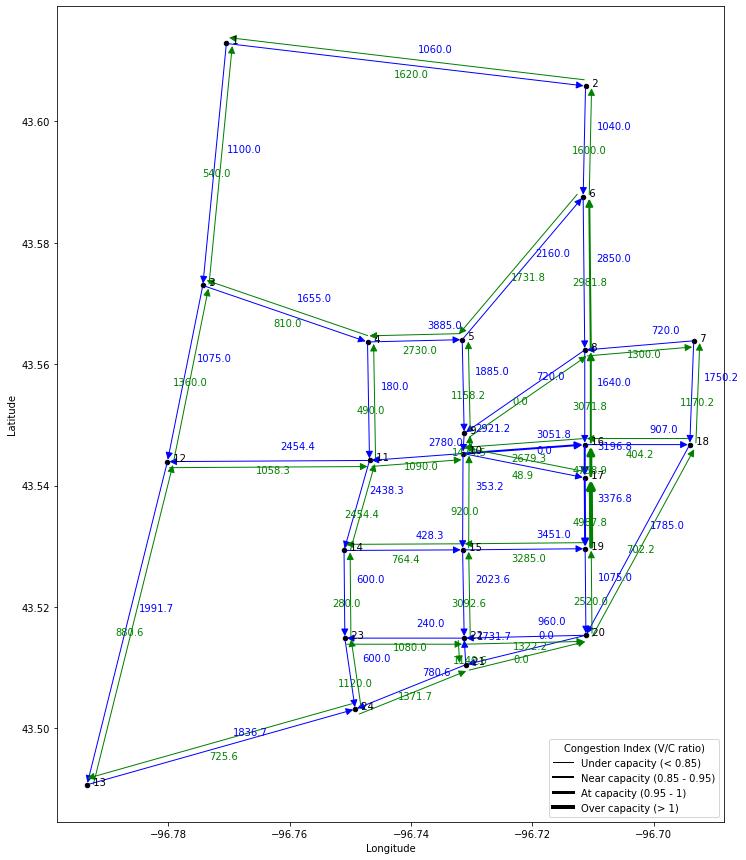

In [154]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from shapely.geometry import Point
import json
import numpy as np
from matplotlib.lines import Line2D

# Read the JSON file into a Python dictionary
data_type = "SiouxFalls"
with open('../data/{}/{}_geo.json'.format(data_type, data_type), 'r') as f:
    loaded_geojson_data = json.load(f)

# Convert the loaded GeoJSON to a Geopandas DataFrame
gdf = gpd.read_file(json.dumps(loaded_geojson_data))

def draw_plot(data, title):
    # Plot the points
    fig, ax = plt.subplots(figsize=(18, 15))
    gdf.plot(ax=ax, markersize=20, color='black', marker='o')

    # # Set global font sizes
    # plt.rcParams.update({
    #     'font.size': 20,
    #     'axes.titlesize': 20,
    #     'axes.labelsize': 20,
    #     'xtick.labelsize': 20,
    #     'ytick.labelsize': 20,
    #     'legend.fontsize': 18
    # })

    # Helper function to offset points for drawing bi-directional edges and annotations
    def offset_points(x1, y1, x2, y2, offset=0.001):
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)
        dx /= length
        dy /= length
        return x1 + offset * dy, y1 - offset * dx, x2 + offset * dy, y2 - offset * dx

    # Function to determine line width based on congestion index
    def get_line_width(congest_index_value):
        if congest_index_value < 0.6:
            return 1  # width for x < 0.6
        elif 0.6 <= congest_index_value <= 0.8:
            return 2  # width for 0.6 <= x <= 0.8
        elif 0.8 < congest_index_value < 1:
            return 3  # width for 0.8 < x < 1
        else:
            return 4  # width for x >= 1


    bidirectional_edges = {}  # To store pairs that are bi-directional
    for (link), flow in data.items():
        point1 = gdf[gdf['id'] == arcs[link][0]].iloc[0]
        point2 = gdf[gdf['id'] == arcs[link][1]].iloc[0]
        
        mid_x = (point1.geometry.x + point2.geometry.x) / 2
        mid_y = (point1.geometry.y + point2.geometry.y) / 2
        
        arrow_color = 'k'
        text_color = 'red'
        
        # Determine the color based on direction
        if arcs[link][0] < arcs[link][1]:  # For demonstration, assuming low to high id is blue
            arrow_color = 'blue'
            text_color = 'blue'
        else:  # high to low id is green
            arrow_color = 'green'
            text_color = 'green'

        # Check if the link is bi-directional
        if (arcs[link][1], arcs[link][0]) in bidirectional_edges:
            x1, y1, x2, y2 = offset_points(point1.geometry.x, point1.geometry.y, point2.geometry.x, point2.geometry.y)
            # arrow = FancyArrowPatch((x1, y1), (x2, y2), mutation_scale=15, arrowstyle='-|>', color=arrow_color, linewidth=congest_index[tuple(arcs[link])])
            arrow = FancyArrowPatch((x1, y1), (x2, y2), mutation_scale=15, arrowstyle='-|>', color=arrow_color, linewidth=get_line_width(congest_index[tuple(arcs[link])]))

            ax.add_patch(arrow)
            ax.text(mid_x - 0.002, mid_y - 0.002, str(round(flow, 1)), color=text_color)
        else:
            arrow = FancyArrowPatch((point1.geometry.x, point1.geometry.y), (point2.geometry.x, point2.geometry.y), mutation_scale=15, arrowstyle='-|>', color=arrow_color, linewidth=get_line_width(congest_index[tuple(arcs[link])]))
            
            ax.add_patch(arrow)
            ax.text(mid_x + 0.002, mid_y + 0.002, str(round(flow, 1)), color=text_color)
            bidirectional_edges[(arcs[link][0], arcs[link][1])] = True  # Mark this link as seen

    # plot points
    for x, y, label in zip(gdf['geometry'].apply(lambda p: p.x), gdf['geometry'].apply(lambda p: p.y), gdf["id"]):
        ax.text(x, y, f"  {label}")

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # fig.suptitle("{}".format(title), fontsize=20)
    # Add text below main title and above subplots
    
    # Note: we follow the definition here:
    # https://www.oregon.gov/odot/Planning/Documents/V-CRatio_DelayPlanningDesignDecisions_SignalizedIntersections.pdf
    # Adjust the legend for the congestion levels
    legend_lines = [Line2D([0], [0], color='black', lw=get_line_width(width)) for width in [0.5, 0.7, 0.9, 1.1]]
    legend_labels = ['Under capacity (< 0.85)', 'Near capacity (0.85 - 0.95)', 'At capacity (0.95 - 1)', 'Over capacity (> 1)']
    ax.legend(legend_lines, legend_labels, title='Congestion Index (V/C ratio)')
    ax.set_aspect(1) #the ratio of x-unit to y-unit

    plt.savefig("../figures/{}.pdf".format(title), bbox_inches='tight')

    plt.show()

# draw_plot(f_vars_opt, "Road flows (congested roads, demand 528, dist 1)")
draw_plot(f_vars_opt, "Road flows (congested roads, demand 576, dist 1)")

In [155]:
sum(f_vars_opt.values())

119428.19178285253

In [156]:
f_vars_opt

{0: 1060.000000000001,
 1: 1100.0000000000177,
 2: 1620.0000000000186,
 3: 1040.0000000000055,
 4: 539.9999999999999,
 5: 1655.0000000000073,
 6: 1075.000000000037,
 7: 810.0000000000281,
 8: 3885.0000000000227,
 9: 180.0,
 10: 2730.0000000000437,
 11: 2160.0000000000327,
 12: 1884.99999999999,
 13: 1600.0000000000232,
 14: 1731.7984141507536,
 15: 2850.0000000000373,
 16: 719.9999999999912,
 17: 1750.1736593787587,
 18: 2981.798414150776,
 19: 1300.0000000000048,
 20: 720.0,
 21: 1640.0000000000791,
 22: 1158.2015858492898,
 23: 0.0,
 24: 2921.24999999999,
 25: 1474.4515858492896,
 26: 2780.000000000001,
 27: 353.2344183000132,
 28: 3051.765581700067,
 29: 0.0,
 30: 490.00000000000006,
 31: 1090.0000000000273,
 32: 2454.413365,
 33: 2438.2541435,
 34: 1359.9999999999984,
 35: 1058.2541434999805,
 36: 1991.7458565001095,
 37: 880.5866350000515,
 38: 1836.7458565000907,
 39: 2454.413365000046,
 40: 428.2541434999355,
 41: 600.0000000000188,
 42: 920.0000000000114,
 43: 764.4133649999999

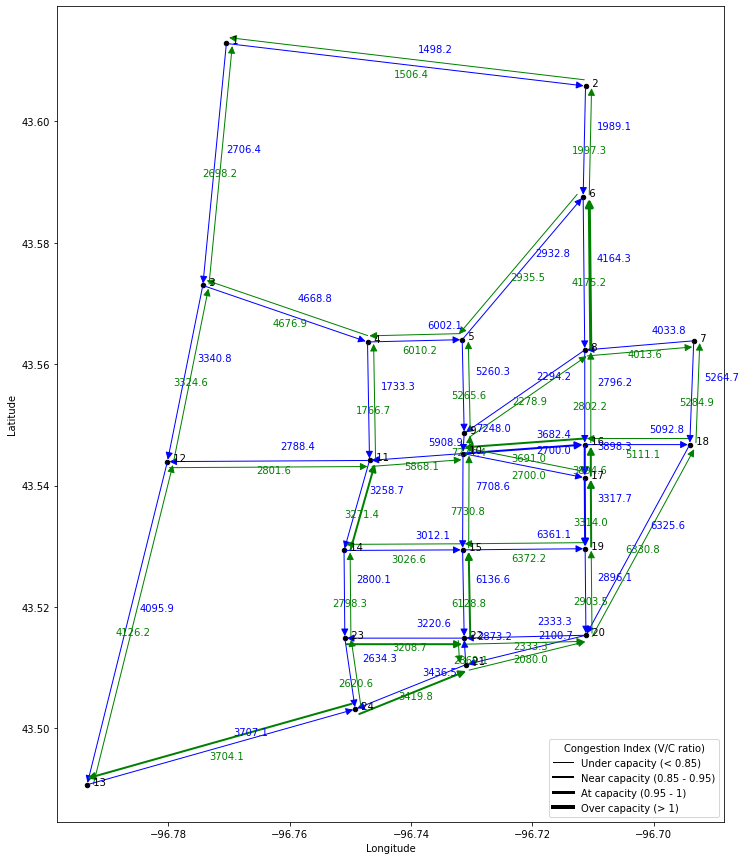

In [157]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from shapely.geometry import Point
import json
import numpy as np
from matplotlib.lines import Line2D

# Read the JSON file into a Python dictionary
data_type = "SiouxFalls"
with open('../data/{}/{}_geo.json'.format(data_type, data_type), 'r') as f:
    loaded_geojson_data = json.load(f)

# Convert the loaded GeoJSON to a Geopandas DataFrame
gdf = gpd.read_file(json.dumps(loaded_geojson_data))

def draw_plot(data, title):
    # Plot the points
    fig, ax = plt.subplots(figsize=(18, 15))
    gdf.plot(ax=ax, markersize=20, color='black', marker='o')

    # # Set global font sizes
    # plt.rcParams.update({
    #     'font.size': 20,
    #     'axes.titlesize': 20,
    #     'axes.labelsize': 20,
    #     'xtick.labelsize': 20,
    #     'ytick.labelsize': 20,
    #     'legend.fontsize': 18
    # })

    # Helper function to offset points for drawing bi-directional edges and annotations
    def offset_points(x1, y1, x2, y2, offset=0.001):
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)
        dx /= length
        dy /= length
        return x1 + offset * dy, y1 - offset * dx, x2 + offset * dy, y2 - offset * dx

    # Function to determine line width based on congestion index
    def get_line_width(congest_index_value):
        if congest_index_value < 0.6:
            return 1  # width for x < 0.6
        elif 0.6 <= congest_index_value <= 0.8:
            return 2  # width for 0.6 <= x <= 0.8
        elif 0.8 < congest_index_value < 1:
            return 3  # width for 0.8 < x < 1
        else:
            return 4  # width for x >= 1


    bidirectional_edges = {}  # To store pairs that are bi-directional
    for (link), flow in data.items():
        point1 = gdf[gdf['id'] == arcs[link][0]].iloc[0]
        point2 = gdf[gdf['id'] == arcs[link][1]].iloc[0]
        
        mid_x = (point1.geometry.x + point2.geometry.x) / 2
        mid_y = (point1.geometry.y + point2.geometry.y) / 2
        
        arrow_color = 'k'
        text_color = 'red'
        
        # Determine the color based on direction
        if arcs[link][0] < arcs[link][1]:  # For demonstration, assuming low to high id is blue
            arrow_color = 'blue'
            text_color = 'blue'
        else:  # high to low id is green
            arrow_color = 'green'
            text_color = 'green'

        # Check if the link is bi-directional
        if (arcs[link][1], arcs[link][0]) in bidirectional_edges:
            x1, y1, x2, y2 = offset_points(point1.geometry.x, point1.geometry.y, point2.geometry.x, point2.geometry.y)
            # arrow = FancyArrowPatch((x1, y1), (x2, y2), mutation_scale=15, arrowstyle='-|>', color=arrow_color, linewidth=congest_index[tuple(arcs[link])])
            arrow = FancyArrowPatch((x1, y1), (x2, y2), mutation_scale=15, arrowstyle='-|>', color=arrow_color, linewidth=get_line_width(congest_index_car[tuple(arcs[link])]))

            ax.add_patch(arrow)
            ax.text(mid_x - 0.002, mid_y - 0.002, str(round(flow, 1)), color=text_color)
        else:
            arrow = FancyArrowPatch((point1.geometry.x, point1.geometry.y), (point2.geometry.x, point2.geometry.y), mutation_scale=15, arrowstyle='-|>', color=arrow_color, linewidth=get_line_width(congest_index[tuple(arcs[link])]))
            
            ax.add_patch(arrow)
            ax.text(mid_x + 0.002, mid_y + 0.002, str(round(flow, 1)), color=text_color)
            bidirectional_edges[(arcs[link][0], arcs[link][1])] = True  # Mark this link as seen

    # plot points
    for x, y, label in zip(gdf['geometry'].apply(lambda p: p.x), gdf['geometry'].apply(lambda p: p.y), gdf["id"]):
        ax.text(x, y, f"  {label}")

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # fig.suptitle("{}".format(title), fontsize=20)
    # Add text below main title and above subplots
    
    # Note: we follow the definition here:
    # https://www.oregon.gov/odot/Planning/Documents/V-CRatio_DelayPlanningDesignDecisions_SignalizedIntersections.pdf
    # Adjust the legend for the congestion levels
    legend_lines = [Line2D([0], [0], color='black', lw=get_line_width(width)) for width in [0.5, 0.7, 0.9, 1.1]]
    legend_labels = ['Under capacity (< 0.85)', 'Near capacity (0.85 - 0.95)', 'At capacity (0.95 - 1)', 'Over capacity (> 1)']
    ax.legend(legend_lines, legend_labels, title='Congestion Index (V/C ratio)')
    ax.set_aspect(1) #the ratio of x-unit to y-unit

    plt.savefig("../figures/{}.pdf".format(title), bbox_inches='tight')

    plt.show()

# draw_plot(f_vars_opt, "Road flows (congested roads, demand 528, dist 1)")
draw_plot(car_flow_final, "Road flows (congested roads, demand 576, dist 2)")

In [158]:
sum(car_flow_final.values())

292534.3671995563